### Fig. 10


In [ ]:

import numpy as np
import pandas as pd
import sys, os
sys.path.append('/home/caoyuyao/dataset_14T/UID-Moji/src') # --qg
from utils import get_hour_list, load_pressure_data, truncate_colormap, LandUse, \
    TcTools, if_in_china_index
from tqdm import tqdm
from datetime import datetime, timedelta
from quality_control import QualityControlTool
from interpolation import idw_interpolate_fastknn, idw_interpolate
import netCDF4 as nc
import matplotlib.pyplot as plt
from visualization import ObservationMap, ProbabilityMatrix
from scipy.io import netcdf
from interpolation import idw_interpolate_fastknn
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.gridspec as gridspec
import matplotlib
import seaborn as sns
import matplotlib.patches as mpatches
from matplotlib import font_manager 
font_path = "/mnt/cyy14/data_qg/old_draw/font"
font_files = font_manager.findSystemFonts(fontpaths=font_path)
for file in font_files:
    font_manager.fontManager.addfont(file)
plt.rcParams["font.sans-serif"] = "Arial"


        
def get_tc_location(tc_year, tc_name, hour_name):   
    # data_dir = '/media/cyy14T/TC_information/'
    data_dir = '/mnt/cyy14/TC_information/' # --qg
    tc_info_dict = np.load(data_dir+'STI-tc_info_dict_2016-2021.npy', allow_pickle = 'True').item()
    tc_info_list = tc_info_dict[(tc_year, tc_name.upper())]

    for i in range(len(tc_info_list)):
        tmp_hour_name = tc_info_list[i][0]
        tmp_lon = tc_info_list[i][1]
        tmp_lat = tc_info_list[i][2]
        tmp_pressure = tc_info_list[i][3]

        d1 = int((tmp_lat - 0)/0.5)
        d2 = int((tmp_lon - 70)/0.5)
        if d1<0 or d1>=110 or d2<0 or d2>=140 or if_in_china_index[d1, d2]==0:
            continue

        if tmp_hour_name == hour_name:
            return tmp_lon, tmp_lat, tmp_pressure


def load_hourly_sphn_data(tc_name = 'HAGUPIT', hour_name = '2019080405'):
    if tc_name.upper() == 'HAGUPIT':
        data_dir = '/mnt/cyy14/2020080400-2020080523_119.0-123.0_27.0-35.0_RF_MD9999_MSL1_N30_MS0.7_sea-level_low_elev_all_users_split_hourly_data/'
    elif tc_name.upper() == 'IN-FA':
        data_dir = '/mnt/cyy14/2021072500-2021073023_115.0-125.0_29.0-40.0_RF_MD9999_MSL1_N30_MS0.7_sea-level_low_elev_all_users_split_hourly_data/'
    elif tc_name.upper() == 'LEKIMA':
        data_dir = '/mnt/cyy14/2019080910-2019081110_117.2-123.2_27.3-33.3_RF_MD9999_MSL1_N30_MS0.7_sea-level_low_elev_all_users_split_hourly_data/'    
    try:
        data = np.load(data_dir + hour_name + '_QCed_smartphone_data.npy')
        return data
    except FileNotFoundError:
        print('Wrong file name!')


def get_tc_pressure_list(source = 'STI', tc_year = 2021, tc_name = 'IN-FA'):
    if tc_name.upper() == 'HAGUPIT':
        hour_list = ['2020080420', '2020080423', '2020080502']
    else:
        hour_list = get_hour_list('2021072605', '2021072923')[::3]

    data_dir = '/mnt/cyy14/TC_information/'
    tc_info_dict = np.load(data_dir+source+'-tc_info_dict_2016-2021.npy', allow_pickle = 'True').item()
    tc_info_list = tc_info_dict[(tc_year, tc_name.upper())]

    tc_pressure_list = []
    for i in range(len(tc_info_list)):
        hour_name = str(tc_info_list[i][0])
        tc_pressure = tc_info_list[i][3]
        if hour_name not in hour_list:
            continue
        tc_pressure_list.append(tc_pressure)
        
    return tc_pressure_list


def get_cover_ratio(tc_lon, tc_lat, pressure_data, resolution = 0.1, box_size = 0.3):
    '''pressure_data: lon, lat, pressure. 3 columns'''
    cover_array = np.zeros((int(box_size*2/resolution), int(box_size*2/resolution)))
    for i in range(pressure_data.shape[0]):
        lon = pressure_data[i, 0]
        lat = pressure_data[i, 1]

        d1 = int((lat - tc_lat + box_size)/resolution)
        d2 = int((lon - tc_lon + box_size)/resolution)

        if d1<0 or d1>=cover_array.shape[0] or d2<0 or d2>=cover_array.shape[1]:
            continue  
        cover_array[d1, d2] = 1

    return np.sum(cover_array)/cover_array.size


def get_cover_ratio_list(resolution = 0.05, box_size = 0.3):
    hour_list = get_hour_list('2021072605', '2021072923')[::3]
    
    cover_ratio_list = []
    cover_ratio_dict = {}
    for hour_name in hour_list:
        data = load_hourly_sphn_data('IN-FA', hour_name)
        
        tc_lon, tc_lat, _ = get_tc_location(2021, 'IN-FA', hour_name)

        start_lon = tc_lon - box_size
        start_lat = tc_lat - box_size

        cover_grid = np.zeros((int(box_size*2/resolution), int(box_size*2/resolution)))
        for i in range(data.shape[0]):
            lon = data[i, 0]
            lat = data[i, 1]

            d1 = int((lat - start_lat)/resolution)
            d2 = int((lon - start_lon)/resolution)

            if d1<0 or d1>=cover_grid.shape[0] or d2<0 or d2>=cover_grid.shape[1]:
                continue  
            cover_grid[d1, d2] = 1
        
        cover_ratio = np.sum(cover_grid)/cover_grid.size
        cover_ratio_list.append(cover_ratio)

        cover_ratio_dict[hour_name] = cover_ratio

    return cover_ratio_list, cover_ratio_dict        


def interquartile_check(data, radius = 0.5):
    '''
    data: 3 columns, lon, lat, pressure
    '''
    start_lat = int(np.nanmin(data[:, 1])*10)/10
    start_lon = int(np.nanmin(data[:, 0])*10)/10

    grid_sphn_dict = {}
    resolution = radius
    thld = 1
    for i in range(data.shape[0]):
        lon = data[i, 0]
        lat = data[i, 1]
        pressure = data[i, 2]

        d1 = int((lat - start_lat)/resolution)
        d2 = int((lon - start_lon)/resolution)
        grid_sphn_dict.setdefault((d1, d2), []).append([lon, lat, pressure])
    

    stacked_data = np.zeros((0, 3))
    for key in grid_sphn_dict:
        grid_sphn_dict[key] = np.array(grid_sphn_dict[key])
        perc_25 = np.nanpercentile(grid_sphn_dict[key][:, 2], 25)
        perc_75 = np.nanpercentile(grid_sphn_dict[key][:, 2], 75)
        inter_range = perc_75 - perc_25
        valid_ind = (grid_sphn_dict[key][:, 2] - perc_75<=thld*inter_range) & \
            (perc_25 - grid_sphn_dict[key][:, 2]<=thld*inter_range)
        
        valid_data = grid_sphn_dict[key][valid_ind]
        stacked_data = np.vstack((stacked_data, valid_data))
    return stacked_data

In [ ]:

hour_list = get_hour_list('2021072605', '2021072923')[::3]
hour_list_INFA = hour_list

station_cover_list = []
sphn_cover_list = []
min_sphn_list = []
bst_mslp_list = []

for hour_name in tqdm(hour_list):
    tc_lon, tc_lat, tc_pressure = get_tc_location(2021, 'IN-FA', hour_name)
    bst_mslp_list.append(tc_pressure)

    station_data = load_pressure_data(hour_name, True)
    radius = 0.6
    region_ind = (station_data[:, 1]>=tc_lon-radius) & (station_data[:, 1]<=tc_lon+radius) & (station_data[:, 2]>=tc_lat-radius) & (station_data[:, 2]<=tc_lat+radius)
    valid_ind = (~np.isnan(station_data[:, 4])) & (station_data[:, 3]<=50)
    station_data = station_data[region_ind&valid_ind, :]
    station_data = interquartile_check(station_data[:, np.array([1, 2, 4])], radius = 0.5)

    sphn_data = load_hourly_sphn_data('IN-FA', hour_name)
    region_ind = (sphn_data[:, 0]>=tc_lon-radius) & (sphn_data[:, 0]<=tc_lon+radius) & (sphn_data[:, 1]>=tc_lat-radius) & (sphn_data[:, 1]<=tc_lat+radius)
    sphn_data = sphn_data[region_ind]
    min_sphn_list.append(np.nanmin(sphn_data[:, 2]))   

    station_cover = get_cover_ratio(tc_lon, tc_lat, station_data, resolution = 0.1, box_size = 0.6)
    sphn_cover = get_cover_ratio(tc_lon, tc_lat, sphn_data, resolution = 0.1, box_size = 0.6)
    station_cover_list.append(station_cover)
    sphn_cover_list.append(sphn_cover)

    
    
hour_list = ['2020080420', '2020080423', '2020080502']
hour_list_HGP = hour_list

station_cover_list_HGP = []
sphn_cover_list_HGP= []
min_sphn_list_HGP = []
bst_mslp_list_HGP = []

for hour_name in tqdm(hour_list):
    try:
        tc_lon, tc_lat, tc_pressure = get_tc_location(2020, 'HAGUPIT', hour_name)
        bst_mslp_list_HGP.append(tc_pressure)
    except TypeError: 
        # 不在陆地上
        continue

    station_data = load_pressure_data(hour_name, True)
    radius = 0.6
    region_ind = (station_data[:, 1]>=tc_lon-radius) & (station_data[:, 1]<=tc_lon+radius) & (station_data[:, 2]>=tc_lat-radius) & (station_data[:, 2]<=tc_lat+radius)
    valid_ind = (~np.isnan(station_data[:, 4])) & (station_data[:, 3]<=50)
    station_data = station_data[region_ind&valid_ind, :]
    '''Interquartile check'''
    station_data = interquartile_check(station_data[:, np.array([1, 2, 4])], radius = 0.5)
    
    sphn_data = load_hourly_sphn_data('HAGUPIT', hour_name)
    region_ind = (sphn_data[:, 0]>=tc_lon-radius) & (sphn_data[:, 0]<=tc_lon+radius) & (sphn_data[:, 1]>=tc_lat-radius) & (sphn_data[:, 1]<=tc_lat+radius)
    sphn_data = sphn_data[region_ind]
    min_sphn_list_HGP.append(np.nanmin(sphn_data[:, 2]))

    station_cover = get_cover_ratio(tc_lon, tc_lat, station_data, resolution = 0.1, box_size = 0.6)
    sphn_cover = get_cover_ratio(tc_lon, tc_lat, sphn_data, resolution = 0.1, box_size = 0.6)

    station_cover_list_HGP.append(station_cover)
    sphn_cover_list_HGP.append(sphn_cover)

    
    

hour_list_LKM =['2019081014',
       '2019081017', '2019081020', '2019081023', '2019081102',
       '2019081105']
hour_list = hour_list_LKM

station_cover_list_LKM = []
sphn_cover_list_LKM= []
min_sphn_list_LKM = []
bst_mslp_list_LKM = []

for hour_name in tqdm(hour_list):
    try:
        tc_lon, tc_lat, tc_pressure = get_tc_location(2019, 'LEKIMA', hour_name)
    except TypeError: 
        continue

    if tc_lon<117.2-0.3 or tc_lon>123.2+0.3 or tc_lat<27.3-0.3 or tc_lat>33.3+0.3:
        continue

    radius = 0.6
    try:
        sphn_data = load_hourly_sphn_data('LEKIMA', hour_name)
        region_ind = (sphn_data[:, 0]>=tc_lon-radius) & (sphn_data[:, 0]<=tc_lon+radius) & (sphn_data[:, 1]>=tc_lat-radius) & (sphn_data[:, 1]<=tc_lat+radius)
        sphn_data = sphn_data[region_ind]
        min_sphn_list.append(np.nanmin(sphn_data[:, 2]))

        min_sphn_list_LKM.append(np.nanmin(sphn_data[:, 2]))
        bst_mslp_list_LKM.append(tc_pressure)
    except TypeError:
        continue

    station_data = load_pressure_data(hour_name, True)
    radius = 0.6
    region_ind = (station_data[:, 1]>=tc_lon-radius) & (station_data[:, 1]<=tc_lon+radius) & (station_data[:, 2]>=tc_lat-radius) & (station_data[:, 2]<=tc_lat+radius)
    valid_ind = (~np.isnan(station_data[:, 4])) & (station_data[:, 3]<=50)
    station_data = station_data[region_ind&valid_ind, :]
    '''Interquartile check'''
    station_data = interquartile_check(station_data[:, np.array([1, 2, 4])], radius = 0.5)

    
    station_cover = get_cover_ratio(tc_lon, tc_lat, station_data, resolution = 0.1, box_size = 0.6)
    sphn_cover = get_cover_ratio(tc_lon, tc_lat, sphn_data, resolution = 0.1, box_size = 0.6)

    station_cover_list_LKM.append(station_cover)
    sphn_cover_list_LKM.append(sphn_cover)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  7.67it/s]


In [ ]:

def get_sphn_lowest_LKM(hour_list):
    # data_dir = '/media/cyy14T/2019080910-2019081110_117.2-123.2_27.3-33.3_RF_MD9999_MSL1_N30_MS0.7_sea-level_low_elev_all_users_split_hourly_data/'
    data_dir = '/mnt/cyy14/\
2019080910-2019081110_117.2-123.2_27.3-33.3_RF_MD9999_MSL1_N30_MS0.7_sea-level_low_elev_all_users_split_hourly_data/'
    tc_info_dict = {}

    tc_tool = TcTools()
    info_list = tc_tool.tc_info_dict[(2019, 'LEKIMA')]
    for i in range(len(info_list)):
        hour_name = info_list[i][0]
        tc_info_dict[hour_name] = info_list[i][1:]

    lowest_sphn_list = []
    bst_list = []
    aws_list = []

    for hour_name in hour_list:
        # print(hour_name)

        tc_lon = round(tc_info_dict[hour_name][0], 1)
        tc_lat = round(tc_info_dict[hour_name][1], 1)
        bst_list.append(tc_info_dict[hour_name][2])

        data = np.load(data_dir+hour_name+'_QCed_smartphone_data.npy')
        # qc_tool = QualityControlTool()
        # _, valid_ind = qc_tool.spatial_check_old(data[:, np.array([1, 2, 3])])
        region_ind = (data[:, 0]>=tc_lon-0.5) & (data[:, 0]<=tc_lon+0.5) & \
            (data[:, 1]>=tc_lat-0.5) & (data[:, 1]<=tc_lat+0.5)
        region_data = data[region_ind] 

        resolution = 0.005
        n1 = n2 = int(1/resolution)
        sum_grid = np.zeros((n1, n2))
        n_grid = np.zeros((n1, n2))
        
        for i in range(region_data.shape[0]):
            lon = region_data[i, 0]
            lat = region_data[i, 1]
            pressure = region_data[i, 2]

            d1 = int((lat - (tc_lat - 0.5))/resolution)
            d2 = int((lon - (tc_lon - 0.5))/resolution)
            try:
                sum_grid[d1, d2] += pressure
                n_grid[d1, d2] += 1
            except IndexError:
                continue
            
        mean_grid = sum_grid/n_grid
        '''Interquartile check'''
        radius = 0.6

        thld = np.nanpercentile(region_data[:, 2], 1)

        lowest_values = np.sort(region_data[:, 2])[:int(region_data.shape[0]*0.1)]
        lowest_sphn_list.append(list(lowest_values))



        pressure_data = load_pressure_data(hour_name, True)
        valid_ind = (~np.isnan(pressure_data[:, 4])) & (pressure_data[:, 3]<=50)
        region_ind = (pressure_data[:, 1]>=tc_lon-radius) & (pressure_data[:, 1]<=tc_lon+radius) & \
            (pressure_data[:, 2]>=tc_lat-radius) & (pressure_data[:, 2]<=tc_lat+radius)
        pressure_data = pressure_data[region_ind & valid_ind]
        aws_list.append(np.nanmin(pressure_data[:, 4]))   


    return lowest_sphn_list, bst_list, aws_list


In [ ]:

valid_tc_hours = ['2020080420', '2020080423', '2020080502']
lowest_sphn_list = []
aws_list = []
for i, hour_name in enumerate(np.sort(valid_tc_hours)):
    tc_lon, tc_lat, tc_pressure = get_tc_location(2020, 'HAGUPIT', hour_name)

    hourly_sphn_data = load_hourly_sphn_data('HAGUPIT', hour_name)

    region_ind = (hourly_sphn_data[:, 0]>=tc_lon-0.6) & (hourly_sphn_data[:, 0]<=tc_lon+0.6) &\
        (hourly_sphn_data[:, 1]>=tc_lat-0.6) & (hourly_sphn_data[:, 1]<=tc_lat+0.6)

    sphn_lons = hourly_sphn_data[:, 0]
    sphn_lats = hourly_sphn_data[:, 1]
    sphn_pressure_list = hourly_sphn_data[:, 2]


    station_data = load_pressure_data(hour_name, True)
    radius = 0.6
    region_ind = (station_data[:, 1]>=tc_lon-radius) & (station_data[:, 1]<=tc_lon+radius) & (station_data[:, 2]>=tc_lat-radius) & (station_data[:, 2]<=tc_lat+radius)
    valid_ind = (~np.isnan(station_data[:, 4])) & (station_data[:, 3]<=50)
    station_data = station_data[region_ind&valid_ind, :]
    '''Interquartile check'''
    station_data = interquartile_check(station_data[:, np.array([1, 2, 4])], radius = 0.5)


    lowest_values = np.sort(sphn_pressure_list)[:int(sphn_pressure_list.shape[0]*0.1)]
    lowest_sphn_list.append(list(lowest_values))

    if i == 0: 

        outlier_ind = (station_data[:, 1]>=120.1) & (station_data[:, 1]<=120.25) & \
            (station_data[:, 2]>=30.3) & (station_data[:, 2]<=30.55)
        aws_list.append(np.nanmin(station_data[~outlier_ind, 2]))
    else:
        aws_list.append(np.nanmin(station_data[:, 2]))

lowest_sphn_list_HGP=lowest_sphn_list
aws_list_HGP=aws_list

In [ ]:


valid_tc_hours = get_hour_list('2021072605', '2021072923')[::3]

lowest_sphn_list = []
aws_list = []
for i, hour_name in enumerate(np.sort(valid_tc_hours)):
    tc_lon, tc_lat, tc_pressure = get_tc_location(2021, 'IN-FA', hour_name)
    hourly_sphn_data = load_hourly_sphn_data('IN-FA', hour_name)
    region_ind = (hourly_sphn_data[:, 0]>=tc_lon-0.6) & (hourly_sphn_data[:, 0]<=tc_lon+0.6) &\
        (hourly_sphn_data[:, 1]>=tc_lat-0.6) & (hourly_sphn_data[:, 1]<=tc_lat+0.6)
    hourly_sphn_data = hourly_sphn_data[region_ind]

    sphn_lons = hourly_sphn_data[:, 0]
    sphn_lats = hourly_sphn_data[:, 1]
    sphn_pressure_list = hourly_sphn_data[:, 2]

    station_data = load_pressure_data(hour_name, True)
    radius = 0.6
    region_ind = (station_data[:, 1]>=tc_lon-radius) & (station_data[:, 1]<=tc_lon+radius) & (station_data[:, 2]>=tc_lat-radius) & (station_data[:, 2]<=tc_lat+radius)
    valid_ind = (~np.isnan(station_data[:, 4])) & (station_data[:, 3]<=50)
    station_data = station_data[region_ind & valid_ind, :]
    '''interquartile check'''
    station_data = interquartile_check(station_data[:, np.array([1, 2, 4])], radius = 0.5)

    lowest_values = np.sort(sphn_pressure_list)[:int(sphn_pressure_list.shape[0]*0.1)]
    lowest_sphn_list.append(list(lowest_values))

    aws_list.append(np.nanmin(station_data[:, 2]))

lowest_sphn_list_INFA=lowest_sphn_list
aws_list_INFA=aws_list

In [ ]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
#sys.path.append('/mnt/cyy14/data_qg/add_exp')
sys.path.append('/home/caoyuyao/dataset_14T/UID-Moji/src')
from utils import TcTools, get_hour_list


tc_tools = TcTools()
tc_lkm=tc_tools.tc_info_dict[(2019, 'LEKIMA')]
ANON_data_dir = '/mnt/cyy14/random_forest_data/random_forest_data_2019_east_test_0.0001/TC_merged_data/'
y_an=[]
for i in tc_lkm:   
    if int(i[0])<=2019081105 and int(i[0])>=2019081014:
        hour=i[0]
        tc_lon=i[1]
        tc_lat=i[2]
        hourly_data=np.load('{path}{hour_name}_QCed_smartphone_data.npy'.format(path=ANON_data_dir, hour_name=hour))
        chosen_data=hourly_data[(hourly_data[:, 0]<=tc_lon+0.6)&(hourly_data[:, 0]>=tc_lon-0.6)&(hourly_data[:, 1]<=tc_lat+0.6)&\
                                (hourly_data[:, 1]>=tc_lat-0.6), 2]
        y_an.append(np.nanmin(chosen_data))


tc_lkm=tc_tools.tc_info_dict[(2020, 'HAGUPIT')]
ANON_data_dir = '/mnt/cyy14/random_forest_data/random_forest_data_2020_HGP_PATH_0.0001/TC_merged_data/'
y_an_HGP=[]
for i in tc_lkm:   
    if int(i[0])>=2020080420 and int(i[0])<=2020080502:
        hour=i[0]
        tc_lon=i[1]
        tc_lat=i[2]
        hourly_data=np.load('{path}{hour_name}_QCed_smartphone_data.npy'.format(path=ANON_data_dir, hour_name=hour))
        chosen_data=hourly_data[(hourly_data[:, 0]<=tc_lon+0.6)&(hourly_data[:, 0]>=tc_lon-0.6)&(hourly_data[:, 1]<=tc_lat+0.6)&\
                                (hourly_data[:, 1]>=tc_lat-0.6), 2]
        y_an_HGP.append(np.nanmin(chosen_data))
        
        
tc_lkm=tc_tools.tc_info_dict[(2021, 'IN-FA')]
ANON_data_dir = '/mnt/cyy14/random_forest_data/random_forest_data_2021_INFA_PATH_0.0001/TC_merged_data/'
y_an_INFA=[]
for i in tc_lkm:   
    if int(i[0])>=2021072605 and int(i[0])<=2021072923:
        hour=i[0]
        tc_lon=i[1]
        tc_lat=i[2]
        hourly_data=np.load('{path}{hour_name}_QCed_smartphone_data.npy'.format(path=ANON_data_dir, hour_name=hour))
        chosen_data=hourly_data[(hourly_data[:, 0]<=tc_lon+0.6)&(hourly_data[:, 0]>=tc_lon-0.6)&(hourly_data[:, 1]<=tc_lat+0.6)&\
                                (hourly_data[:, 1]>=tc_lat-0.6), 2]
        y_an_INFA.append(np.nanmin(chosen_data))

    

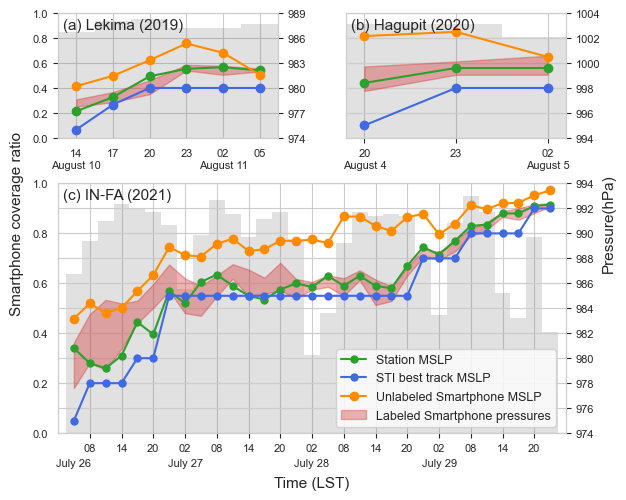

In [ ]:


mx=0.17
x0=0.3
my=0.15
y0=0.208
x2=0.025

y1=1-2*my-3*y0
x1=1-2*mx-2*x0

def draw_text(text, x, y):
    textx=0.007/x
    texty=1-0.008/y
    textpad='round,pad=0.2'
    
    plt.text(textx,texty, s = text, zorder=9999999, verticalalignment='top', horizontalalignment='left',\
fontsize=11, transform=ax.transAxes, bbox=dict(boxstyle=textpad, fc='white', ec='k',lw=1 ,alpha=0))
    
    return text


fig=plt.figure(1)
plt.subplots_adjust(wspace = 0.20, hspace = 0.25)
plt.subplots_adjust(left=0.17, right=0.85, top=0.83, bottom=0.15)
fig.set_size_inches(8, 6)

sns.set_style('whitegrid')

# 利奇马
markersize = 6
hour_list = hour_list_LKM

lowest_sphn_list, bst_list, aws_list = get_sphn_lowest_LKM(hour_list)
lowest_mid_list = [np.mean(values) for values in lowest_sphn_list]
lowest_min_list = [np.nanmin(values) for values in lowest_sphn_list]
lowest_max_list = [np.nanmax(values) for values in lowest_sphn_list]

lowest_mid_list = np.array(lowest_mid_list)
lowest_min_list = np.array(lowest_min_list)
lowest_max_list = np.array(lowest_max_list)

ax=plt.axes([mx, my+2*y0+y1, x0-x2, y0])
ax2=ax.twinx()




plt.sca(ax2)
sns.set_style('whitegrid')
plt.plot(np.arange(len(lowest_sphn_list)), aws_list, marker = 'o',color = 'tab:green', label = 'Station', markersize = markersize)

plt.plot(np.arange(len(lowest_sphn_list)), bst_list, marker = 'o', label = 'STI Best-track', markersize = markersize, color='#4169E1')


plt.plot(np.arange(len(y_an)), y_an, marker = 'o', label = 'ANON smartphone', markersize = markersize, color='darkorange')

jma_bst_list = [975.0, 980.0, 980.0]
jtwc_bst_list = [953.0, 965.0, 969.0,  968.0]


plt.fill_between(np.arange(len(lowest_mid_list)), lowest_min_list, lowest_max_list, color = 'tab:red', alpha = 0.35, label = 'Smartphone')


labels = [datetime.strptime(hour_name, '%Y%m%d%H').strftime('%m-%d %H:00') for hour_name in hour_list]
plt.yticks(np.arange(974, 989+1, 3), [str(num) for num in range(974, 989+1, 3)], fontsize = 8)
plt.ylim((974,989))

plt.grid(False)


plt.sca(ax)
sns.set_style('whitegrid')
plt.bar(np.arange(len(sphn_cover_list_LKM)),sphn_cover_list_LKM, color = 'dimgray', width=1, alpha=0.2, ls='None')
plt.text(0, -0.22, s = 'August 10', fontsize=8, zorder=9999999,verticalalignment="center", horizontalalignment="center")
plt.text(4, -0.22, s = 'August 11', fontsize=8, zorder=9999999,verticalalignment="center", horizontalalignment="center")


hour_list = hour_list_LKM
labels = [datetime.strptime(hour_name, '%Y%m%d%H').strftime('%H') for hour_name in hour_list]
plt.ylim((0,1))
plt.xlim((-0.5,len(hour_list)-0.5))
plt.yticks(np.arange(0, 1+0.2, 0.2), [str(round(num,1)) for num in np.arange(0, 1+0.2, 0.2)], fontsize = 8)
plt.xticks(np.arange(0, len(hour_list), 1), labels[::1], fontsize = 8)

plt.grid(True)


draw_text("(a) Lekima (2019)",x0,y0)




markersize = 6

lowest_mid_list = [np.mean(values) for values in lowest_sphn_list_HGP]
lowest_min_list = [np.nanmin(values) for values in lowest_sphn_list_HGP]
lowest_max_list = [np.nanmax(values) for values in lowest_sphn_list_HGP]

lowest_mid_list = np.array(lowest_mid_list)
lowest_min_list = np.array(lowest_min_list)
lowest_max_list = np.array(lowest_max_list)

sti_bst_list = get_tc_pressure_list('STI', 2020, 'HAGUPIT')
jma_bst_list = get_tc_pressure_list('JMA', 2020, 'HAGUPIT')

ax=plt.axes([mx+x0+x1, my+2*y0+y1, x0-x2, y0])

ax2=ax.twinx()




plt.sca(ax2)
plt.plot(np.arange(len(lowest_sphn_list_HGP)), aws_list_HGP, marker = 'o',color = 'tab:green', label = 'Station', markersize = markersize)

plt.plot(np.arange(len(lowest_sphn_list_HGP)), sti_bst_list, marker = 'o', label = 'STI Best-track', markersize = markersize, color='#4169E1')
jma_bst_list = [998, 1000]


plt.fill_between(np.arange(len(lowest_mid_list)), lowest_min_list, lowest_max_list, color = 'tab:red', alpha = 0.35, label = 'Smartphone')


plt.plot(np.arange(len(y_an_HGP)), y_an_HGP, marker = 'o', label = 'ANON smartphone', markersize = markersize, color='darkorange')
draw_text("(b) Hagupit (2020)", x0, y0)

hour_list = ['2020080420', '2020080423', '2020080502']
labels = [datetime.strptime(hour_name, '%Y%m%d%H').strftime('%m-%d %H:00') for hour_name in hour_list]
plt.xticks(np.arange(0, 3, 1), labels[::1], fontsize = 8)
plt.yticks(np.arange(994, 1004+1, 2), [str(num) for num in range(994, 1004+1, 2)], fontsize = 8)
plt.ylim(994, 1004)



plt.sca(ax)
sns.set_style('whitegrid')
plt.bar(np.arange(len(sphn_cover_list_HGP)),sphn_cover_list_HGP, color = 'dimgray', width=1, alpha=0.2, ls='None')
plt.text(0, -0.22, s = 'August 4', fontsize=8, zorder=9999999,verticalalignment="center", horizontalalignment="center")
plt.text(2, -0.22, s = 'August 5', fontsize=8, zorder=9999999,verticalalignment="center", horizontalalignment="center")



hour_list = hour_list_HGP
labels = [datetime.strptime(hour_name, '%Y%m%d%H').strftime('%H') for hour_name in hour_list]
plt.ylim((0,1))
plt.xlim((-0.2,len(hour_list)-0.8))
plt.yticks(np.arange(0, 1+0.2, 0.2),[], fontsize = 8)
plt.xticks(np.arange(0, len(hour_list), 1), labels[::1], fontsize = 8)
plt.tick_params(bottom=True, top=False, left=False, right=False)
plt.grid(True)





sns.set_style('whitegrid')
hour_list = get_hour_list('2021072605', '2021072923')[::3]

def plot_pressure_ts(save = True):
    global line_list
    markersize = 5

    lowest_mid_list = [np.mean(values) for values in lowest_sphn_list_INFA]
    lowest_min_list = [np.nanmin(values) for values in lowest_sphn_list_INFA]
    lowest_max_list = [np.nanmax(values) for values in lowest_sphn_list_INFA]

    lowest_mid_list = np.array(lowest_mid_list)
    lowest_min_list = np.array(lowest_min_list)
    lowest_max_list = np.array(lowest_max_list)

    sti_bst_list = get_tc_pressure_list('STI', 2021, 'IN-FA')
    jma_bst_list = get_tc_pressure_list('JMA', 2021, 'IN-FA')

    cover_ratio_list, _ = get_cover_ratio_list(resolution=0.1) # --qg

    diff = np.array(lowest_min_list) - np.array(sti_bst_list)
    
    n_positive = 0
    n_negative = 0
    diff_str_list = []
    positive_cover_ratio_list = []
    negative_cover_ratio_list = []

    hour_list = get_hour_list('2021072605', '2021072923')[::3]    

    for i, value in enumerate(diff):
        diff_str_list.append("{:.2f}".format(value))
        if value>0:
            n_positive += 1
            positive_cover_ratio_list.append(cover_ratio_list[i])
        else:
            n_negative += 1
            negative_cover_ratio_list.append(cover_ratio_list[i])

    a1,=plt.plot(np.arange(len(lowest_sphn_list_INFA)), aws_list_INFA, marker = 'o',color = 'tab:green', label = 'Station', markersize = markersize)
    a2,=plt.plot(np.arange(len(lowest_sphn_list_INFA)), sti_bst_list, marker = 'o', label = 'STI Best-track', markersize = markersize, color='#4169E1')

    a3=plt.fill_between(np.arange(len(lowest_mid_list)), lowest_min_list, lowest_max_list, color = 'tab:red', alpha = 0.35, label = 'Smartphone')
    hour_list = get_hour_list('2021072605', '2021072923')[::3]
    labels = [datetime.strptime(hour_name, '%Y%m%d%H').strftime('%H') for hour_name in hour_list]
    plt.yticks(np.arange(974, 994+2, 2), [str(num) for num in range(974, 994+2, 2)], fontsize = 8)
    plt.xlabel('Time (LST)', fontsize = 11)
    plt.ylim((974,994))

    return positive_cover_ratio_list, negative_cover_ratio_list, [a1,a2,a3]


def draw_cover_ratio():
    cover_ratio_list, cover_ratio_dict = get_cover_ratio_list(resolution=0.1)
    plt.bar(np.arange(len(sphn_cover_list)), sphn_cover_list, color = 'dimgray', width=1, alpha=0.2, ls='None', zorder=999)
    
    hour_list = get_hour_list('2021072605', '2021072923')[::3]
    labels = [datetime.strptime(hour_name, '%Y%m%d%H').strftime('%H') for hour_name in hour_list]
    plt.ylim((0,1))
    plt.yticks(np.arange(0, 1+0.2, 0.2), [str(round(num,1)) for num in np.arange(0, 1+0.2, 0.2)], fontsize = 8)
    plt.xticks(np.arange(1, len(hour_list), 2), labels[1::2], fontsize = 8)
    plt.xlim((-1,len(hour_list)))
    
    plt.tick_params(bottom=True, top=False, left=False, right=False)

ax=plt.axes([mx, my, 2*x0+x1-x2, 2*y0])    

ax2=ax.twinx()



plt.sca(ax2)
positive_cover_ratio_list, negative_cover_ratio_list, draw_list = plot_pressure_ts(save = True)

plt.sca(ax2)



plt.plot(np.arange(len(y_an_INFA)), y_an_INFA, marker = 'o', label = 'ANON smartphone', markersize = markersize, color='darkorange')

plt.grid(True)
ha,la= plt.gca().get_legend_handles_labels()


plt.sca(ax)
draw_cover_ratio()
a2, la=plt.gca().get_legend_handles_labels()

legend_list=[ha[0], ha[1], ha[3], ha[2]]

plt.text(0, -0.12, s = 'July 26', fontsize=8, zorder=9999999,verticalalignment="center", horizontalalignment="center")
plt.text(7, -0.12, s = 'July 27', fontsize=8, zorder=9999999,verticalalignment="center", horizontalalignment="center")
plt.text(15, -0.12, s = 'July 28', fontsize=8, zorder=9999999,verticalalignment="center", horizontalalignment="center")
plt.text(23, -0.12, s = 'July 29', fontsize=8, zorder=9999999,verticalalignment="center", horizontalalignment="center")
plt.text(15, -0.2, s = 'Time (LST)', fontsize=11, zorder=9999999,verticalalignment="center", horizontalalignment="center")




draw_text("(c) IN-FA (2021)", 2*x0+x1, 2*y0)

fig.text(0.11, 0.5, 'Smartphone coverage ratio', va='center', rotation='vertical', fontsize=11)
fig.text(0.85, 0.5, 'Pressure(hPa)', va='center', rotation='vertical', fontsize=11)


fig.legend(legend_list, ["Station MSLP","STI best track MSLP", "Unlabeled Smartphone MSLP", "Labeled Smartphone pressures" ], \
           fontsize = "9", loc = 'lower right', bbox_to_anchor=[0.8,0.15])


fig_dir = '/mnt/cyy14/data_qg/old_draw/submission1/'
plt.savefig(fig_dir + 's2.pdf', dpi = 300, format='pdf', bbox_inches = 'tight')
